# Toxic comment classification 

## Importing the libraries and loading the data

In [7]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [8]:
df = pd.read_csv('train.csv')

In [9]:
df.shape

(159571, 8)

In [10]:
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [11]:
df.tail(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [12]:
# Lets have a look at one of the comment we have

df.iloc[0]['comment_text'] 

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [13]:
df.iloc[10]['comment_text']

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [14]:
# Have a look at how the toxic comments looks like in our dataset.

df[df['toxic']==1].head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0


In [15]:
df.iloc[12]['comment_text']

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'


## Preprocess The data

In [16]:
from tensorflow.keras.layers import TextVectorization

In [17]:
X = df['comment_text']  # all the comments
y = df[df.columns[2:]].values  # all the other things except the comments i.e, labels in the numpy array format so that we can train our model

In [18]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [19]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [20]:
MAX_FEATURES = 200000 # number of words in the vocab
# more the words more the embedings and more the effectiveness of the model

In [21]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                              output_sequence_length = 1800,
                              output_mode = 'int')

In [22]:
vectorizer.adapt(X.values)  #does the vectorization process or learn all the words

In [23]:
vectorizer('I am human and I live in this world ')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  8,  74, 768, ...,   0,   0,   0], dtype=int64)>

In [24]:
vectorized_text = vectorizer(X.values)

In [25]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [27]:
# create the new dataset or the tensorflow data pipeline
#MCSHBP- map, cache , shuffle , batch , prefetch from_tensor_slices, ist_file

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [28]:
batch_X,batch_y = dataset.as_numpy_iterator().next()

In [29]:
batch_X.shape

(16, 1800)

In [30]:
batch_y.shape

(16, 6)

## Partitioning the data

In [31]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [32]:
len(train)  # batches

6981

In [33]:
len(val)

1994

In [34]:
len(test)

997

## Build the deep neural network

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional,Dense,Embedding

In [63]:
model = Sequential()
# first create the embedding layer +1 is for unknown words
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation = 'tanh'))) # tanh for gpu acceleration
# feature extractor fully connected layers
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
#final layer mapd to the different outputs we will be obtaining
model.add(Dense(6,activation = 'sigmoid'))
# sigmoid function will convert the output we are obtaining somewhere between 0 and 1


In [64]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [67]:
history = model.fit(train,epochs=,validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 10037s 1s/step - loss: 0.0554 - val_loss: 0.0464
Epoch 2/5
6981/6981 [==============================] - 9978s 1s/step - loss: 0.0452 - val_loss: 0.0423
Epoch 3/5
6981/6981 [==============================] - 11415s 2s/step - loss: 0.0408 - val_loss: 0.0366
Epoch 4/5
6981/6981 [==============================] - 10712s 2s/step - loss: 0.0363 - val_loss: 0.0319
Epoch 5/5
6981/6981 [==============================] - 10573s 2s/step - loss: 0.0332 - val_loss: 0.0277


In [35]:
history.history

NameError: name 'history' is not defined

In [ ]:
model.save('toxic_comment_classification.h5')

In [164]:
import matplotlib.pyplot as plt

<Figure size 576x360 with 0 Axes>

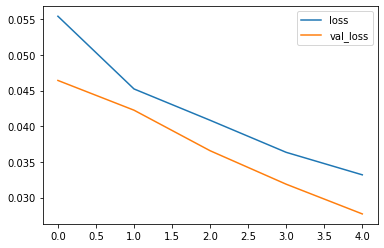

In [165]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [177]:
history??

##  Make Predictions

In [36]:
batch = test.as_numpy_iterator().next()

<TakeDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [37]:
input_text = vectorizer("You freaking suck!")

In [38]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7113,  396, ...,    0,    0,    0], dtype=int64)>

In [39]:
(model.predict(np.expand_dims(input_text,0 )) >0.5).astype(int)

1/1 [==============================] - 4s 4s/step


array([[1, 0, 1, 0, 1, 0]])

In [40]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 151ms/step


In [41]:
batch_X , batch_y = test.as_numpy_iterator().next()

In [42]:
df.columns[2::]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [43]:
(model.predict(batch_X) >0.5).astype(int)

1/1 [==============================] - 0s 309ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [44]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [ ]:
lstm


cnn


logistic regression


svm




final review:

    intragram
    
    django/ flask
    
    host


    

synopsis:
    (timeline)
    

-----------------------------
final sem :
    1) multilingual
    
    2) post sentiment analyis
    
    
    
    

# Evaluating the model

In [45]:
from tensorflow.keras.metrics import Precision , Recall , CategoricalAccuracy

In [46]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [47]:
for batch in test.as_numpy_iterator():
    X_true,y_true = batch # unpacking the batch
    yhat = model.predict(X_true)  #predictions
    
    y_true = y_true.flatten() #flatten redictions
    y_hat = yhat.flatten()
    
    pre.update_state(y_true,y_hat)
    re.update_state(y_true,y_hat)
    acc.update_state(y_true,y_hat)
    

1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 217ms/step


In [48]:
print(f'precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

precision:0.8619518876075745,Recall:0.8675968050956726,Accuracy:0.49448344111442566


# Test and Gardio app creation

In [105]:
!pip install gradio jinja2


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 5.3/5.3 MB 2.4 MB/s eta 0:00:00
     -------------------------------------- 212.9/212.9 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 56.6/56.6 kB 2.9 MB/s eta 0:00:00
     -------------------------------------- 138.8/138.8 kB 2.7 MB/s eta 0:00:00
     -------------------------------------- 319.7/319.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 98.6/98.6 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.9/1.9 MB 2.5 MB/s eta 0:00:00
     -------------------------------------- 197.5/197.5 kB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 54.9/54.9 kB 1.4 MB/s eta 0:00:00

In [2]:
import gradio as gr

In [3]:
input_str = vectorizer('bitch')

NameError: name 'vectorizer' is not defined

In [50]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 152ms/step


In [52]:
res>0.5

array([[ True, False,  True, False,  True, False]])

In [4]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx,col in enumerate(df.columns[2:]):
        text +='{}:{}\n'.format(col,results[0][idx]>0.5)
    return text

In [5]:
interface = gr.Interface(fn = score_comment,
                        inputs = gr.inputs.Textbox(lines=2,placeholder = 'comment to score'),outputs = 'text')

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [6]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://ad189d2c3f16a694.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x246cdde8520>,
 'http://127.0.0.1:7860/',
 'https://ad189d2c3f16a694.gradio.app')

Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\routes.py", line 298, in run_predict
    output = await app.blocks.process_api(
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 790, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 697, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages

# Lets find out the test accuracy

In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('toxic_comment_classification.h5')

In [53]:
test_df = pd.read_csv('test.csv')

In [54]:
y_test = pd.read_csv('test_labels.csv')

In [55]:
X_test = test_df['comment_text']

In [56]:

y_test =y_test[y_test.columns[2:]].values
y_test

array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       ...,
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]], dtype=int64)

In [57]:
vectorized_text_test = vectorizer(X_test.values)

In [58]:
dataset_test = tf.data.Dataset.from_tensor_slices((vectorized_text_test,y_test))
dataset_test = dataset_test.cache()
dataset_test = dataset_test.shuffle(160000)
dataset_test = dataset_test.batch(16)
dataset_test = dataset_test.prefetch(8)

In [59]:
batch_X_test,batch_y_test = dataset_test.as_numpy_iterator().next()

In [60]:
batch_X_test.shape

(16, 1800)

In [61]:
batch_y_test.shape

(16, 5)

In [62]:
test_data = dataset_test.take(int(len(dataset)*1))

In [63]:
batch_X_test , batch_y_test = test_data.as_numpy_iterator().next()

In [64]:
(model.predict(batch_X_test) >0.5).astype(int)

1/1 [==============================] - 0s 366ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [66]:
batch_y_test

array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0]], dtype=int64)

In [67]:
for batch in test.as_numpy_iterator():
    X_true_test,y_true_test = batch # unpacking the batch
    yhat_test = model.predict(X_true_test)  #predictions
    
    y_true_test = y_true_test.flatten() #flatten redictions
    y_hat_test = yhat_test.flatten()
    
    pre.update_state(y_true_test,y_hat_test)
    re.update_state(y_true_test,y_hat_test)
    acc.update_state(y_true_test,y_hat_test)

1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 225ms/step


1/1 [==============================] - 0s 222ms/step


In [68]:
print(f'precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

precision:0.8464188575744629,Recall:0.856997549533844,Accuracy:0.5070210695266724
